In [1]:
card_name = 'Cat_q2var_sys_test'

In [2]:
fit_real_data = True

# Import

In [3]:
import sys, os
from glob import glob
sys.path.append('../lib')
import itertools

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

import uproot as ur
import ROOT as rt
rt.gErrorIgnoreLevel = rt.kError
rt.RooMsgService.instance().setGlobalKillBelow(rt.RooFit.ERROR)
import root_numpy as rtnp

from analysis_utilities import drawOnCMSCanvas, extarct, extarct_multiple, createSel
from histo_utilities import create_TH1D, create_TH2D, std_color_list
from cebefo_style import Set_2D_colz_graphics
from gridVarQ2Plot import plot_gridVarQ2
from progressBar import ProgressBar

import CMS_lumi, tdrstyle
tdrstyle.setTDRStyle()
CMS_lumi.writeExtraText = 1

if fit_real_data:
    CMS_lumi.extraText = "Preliminary"
else:
    CMS_lumi.extraText = "Simulation Preliminary"

donotdelete = []

Welcome to JupyROOT 6.12/07


# Create histograms file

In [5]:
file_loc = {
'mu'   : '../data/cmsMC_private/BPH_Tag-B0_MuNuDmst-pD0bar-kp_13TeV-pythia8_Hardbbbar_PTFilter5_0p0-evtgen_ISGW2/jobs_B2DstMu_crab/out_CAND_*.root',
'tau'  : '../data/cmsMC_private/BPH_Tag-B0_TauNuDmst-pD0bar-kp-t2mnn_pythia8_Hardbbbar_PTFilter5_0p0-evtgen_ISGW2_PU20_10-2-3/jobs_B2DstMu_crab/out_CAND_*.root'
}
if fit_real_data:
    file_loc['data'] = '../data/cmsRD/ParkingBPH1/Run2018D-05May2019promptD-v1_RDntuplizer_B2DstMu_191104_CAND.root'

In [6]:
dSet = {}
recreate = False
for n, filepath in file_loc.iteritems():
    print n
    fskimmed_name = '../data/_root/skimmed4combine/' + n + '.root'
    if os.path.isfile(fskimmed_name) and not recreate:
        dSet[n] = rtnp.root2array(fskimmed_name)
    else:
        tree = rt.TChain('outA/Tevts')
        for fn in glob(filepath):
            tree.Add(fn)
    
        pb = ProgressBar(maxEntry=tree.GetEntries())
        N_accepted_cand = []
        output = []
        for i_ev, ev in enumerate(tree):
            pb.show(i_ev)
            N_acc = 0
            
            aux = ev.trgMu_pt > 13
            aux &= ev.trgMu_sigdxy > 6.5
            if not aux: 
                continue
            
            for j in range(ev.pval_piK.size()):
                aux = ev.pval_piK[j] > 0.1
                aux &= ev.K_pt[j] > 0.8
                aux &= abs(ev.K_eta[j]) < 2.5
                aux &= ev.pi_pt[j] > 0.8
                aux &= abs(ev.pi_eta[j]) < 2.5
                aux &= abs(ev.mass_piK[j] - 1.86) < 0.04
                if not aux: 
                    continue
                
                aux = ev.pis_pt[j] > 0.5
                aux &= ev.pval_D0pis[j] > 0.1
                aux &= abs(ev.mass_D0pis[j] - 2.01) < 0.03
                aux &= ev.sigdxy_pis_PV[j] > 2
                aux &= ev.mass_D0pis[j] < ev.mass_piK[j] + 0.16
                aux &= ev.pval_D0pismu[j] > 0.1
                aux &= ev.cos_D0pismu_PV[j] > 0.99
                if not aux: 
                    continue
                    
                N_acc += 1
                aux = (ev.q2_D0pismu[j], ev.Est_mu_D0pismu[j], ev.M2_miss_D0pismu[j])
                if not n == 'data':
                    aux += (ev.MC_B_pt, ev.MC_B_eta)
                if n == 'tau' or n == 'mu':
                    aux += (
                           ev.wh_CLNCentral,
                           ev.wh_CLNR0Down,
                           ev.wh_CLNR0Up,
                           ev.wh_CLNR1Down,
                           ev.wh_CLNR1Up,
                           ev.wh_CLNR2Down,
                           ev.wh_CLNR2Up,
                           ev.wh_CLNRhoSqDown,
                           ev.wh_CLNRhoSqUp,
                    )
                
                output.append(aux)
            
            if N_acc > 0:
                N_accepted_cand.append(N_acc)
                
        leafs_names = ['q2', 'Est_mu', 'M2_miss']
        if not n == 'data':
            leafs_names += ['MC_B_pt', 'MC_B_eta']
        if n == 'tau' or n == 'mu':
            leafs_names += ['wh_CLNCentral', 'wh_CLNR0Down', 'wh_CLNR0Up', 'wh_CLNR1Down', 'wh_CLNR1Up', 'wh_CLNR2Down', 'wh_CLNR2Up', 'wh_CLNRhoSqDown', 'wh_CLNRhoSqUp']

        dtypes = []
        for nl in leafs_names:
            dtypes.append((nl, np.float32))
            
        dSet[n] = np.array(output, dtype=dtypes)
        if not os.path.isdir(os.path.dirname(fskimmed_name)):
            os.makedirs(os.path.dirname(fskimmed_name))
        rtnp.array2root(dSet[n], fskimmed_name, treename='Tevts', mode='RECREATE')
        
    aux = dSet[n].dtype.fields.keys()[0]
    print 'Events:', dSet[n][aux].shape[0]
    print ''

mu
Events: 13790

tau
Events: 1840

data
Events: 101814



In [7]:
binning = {
    'q2'      : [4, -2, 10.7],
    'M2_miss' : [20, -3, 6],
    'Est_mu'  : [20, 0.50, 2.500]
}

In [8]:
class PTCalibration:
    def __init__(self, calibration_dic=None, calibration_file=None):
        if not calibration_dic is None:
            self.calibration_dic = calibration_dic
            d = calibration_dic
        elif not calibration_file is None:
            d = {}
            lines = open(calibration_file, 'r').readlines()
            keys = lines[0][1:-1].split('\t')
            for k in keys: d[k] = []
            
            for l in lines[1:]:
                l = l[:-1]
                v = l.split('\t')
                for i in range(len(v)):
                    d[keys[i]].append(float(v[i]))
            
            self.calibration_dic = d
        else:
            raise
        
        self.f = {}
        self.f['C'] = interp1d(d['pt'], d['w'], 
                               fill_value=(d['w'][0], d['w'][-1]),
                               bounds_error=False,
                               kind='cubic'
                                                )
        self.f['Up'] = interp1d(d['pt'], d['wUp'], 
                               fill_value=(d['wUp'][0], d['wUp'][-1]),
                               bounds_error=False,
                               kind='cubic'
                                                )
        self.f['Down'] = interp1d(d['pt'], d['wDown'], 
                               fill_value=(d['wDown'][0], d['wDown'][-1]),
                               bounds_error=False,
                               kind='cubic'
                                                )
cal_pT = PTCalibration(calibration_file='../data/calibration/B02JPsiKst_pt.txt')

In [35]:
histo = {}
for i_q2 in range(binning['q2'][0]):
    w_q2 = (binning['q2'][2] - binning['q2'][1])/binning['q2'][0]
    q2_l = binning['q2'][1] + w_q2 * i_q2
    q2_h = binning['q2'][1] + w_q2 * (i_q2+1)

    for var in ['M2_miss', 'Est_mu']:
        cat_name = var+'_q2-'+str(i_q2)
        histo[cat_name] = {}
        for k,d in dSet.iteritems():          
            q2_bin = np.logical_and(d['q2'] > q2_l, d['q2'] < q2_h)
            if k == 'data':
                histo[cat_name][k] = create_TH1D(d[var][q2_bin], 
                                                 name=k, title=k,
                                                 binning=binning[var],
                                                 opt='underflow,overflow'
                                                )
            elif k in ['mu', 'tau']:
                for k_wpT in ['C', 'Up', 'Down']:
                    h_name = k
                    if k_wpT != 'C':
                        h_name += '__B0pT' + k_wpT
                        
                    w = cal_pT.f[k_wpT](d['MC_B_pt'][q2_bin])
                    
                    sel_q2 = np.logical_and(d['q2'] > binning['q2'][1], d['q2'] < binning['q2'][2])
                    norm = np.sum(cal_pT.f[k_wpT](d['MC_B_pt'][sel_q2]))
                    h = create_TH1D(d[var][q2_bin], name=h_name, title=h_name, 
                                    binning=binning[var], 
                                    opt='underflow,overflow',
                                    weights=w,
                                    scale_histo=1./norm,
                                   )
                    
                    N = d['MC_B_pt'][sel_q2].shape[0]
                    p_max = 1 - np.power(0.68/2., 1./N)
                    for i in range(1, h.binning[0]+1):
                        if h.GetBinError(i) == 0:
                            h.SetBinError(i, p_max)
                    
                    histo[cat_name][h_name] = h

Generate Pseudo-data

In [36]:
if fit_real_data:
    rawR_inj = 0.2
    N_exp = 0
    N_mu = 0
    N_tau = 0
    for k, h_dic in histo.iteritems():
        if 'Est_mu' in k:
            N_exp += h_dic['data'].Integral()
            N_mu += h_dic['mu'].Integral()
            N_tau += h_dic['tau'].Integral()
    N_B2mu_inj = N_exp/(1+rawR_inj)
    print 'Number of data events: {:.0f}'.format(N_exp)
    print 'Total norm'
    print 'Mu: {:.3f}'.format(N_mu)
    print 'Tauu: {:.3f}'.format(N_tau)
else:    
    rawR_inj = 0.1
    N_B2mu_inj = 5000

    n_mu = np.random.poisson(lam=N_B2mu_inj)
    idx_mu = np.random.randint(0, dSet['mu']['q2'].shape[0], size=(n_mu, ))

    n_tau = np.random.poisson(lam=N_B2mu_inj*rawR_inj)
    idx_tau = np.random.randint(0, dSet['tau']['q2'].shape[0], size=(n_tau, ))

    pseudo_data = {}
    for var in binning.keys():
        pseudo_data[var] = np.concatenate((dSet['mu'][var][idx_mu], 
                                           dSet['tau'][var][idx_tau]
                                          ))

    for i_q2 in range(binning['q2'][0]):
        w_q2 = (binning['q2'][2] - binning['q2'][1])/binning['q2'][0]
        q2_l = binning['q2'][1] + w_q2 * i_q2
        q2_h = binning['q2'][1] + w_q2 * (i_q2+1)

        for var in ['M2_miss', 'Est_mu']:
            cat_name = var+'_q2-'+str(i_q2)

            sel = np.logical_and(pseudo_data['q2'] > q2_l, pseudo_data['q2'] < q2_h)

            histo[cat_name]['data'] = create_TH1D(pseudo_data[var][sel], 
                                             name='dataObs', title='data obs',
                                             binning=binning[var],
                                             opt='underflow,overflow'
                                            )

    print n_mu, n_tau
    print 'r_toy = {:.2f}%'.format(100.*n_tau/n_mu)

Number of data events: 99105
Total norm
Mu: 1.000
Tauu: 1.000


In [37]:
histo_file_dir = '../data/_root/histos4combine/'
if not os.path.isdir(histo_file_dir):
    os.makedirs(histo_file_dir)
histo_file_loc = {}
for cat_name, h_dic in histo.iteritems():
    histo_file_loc[cat_name] = histo_file_dir+'{}_{}.root'.format(card_name, cat_name)
    tf = rt.TFile(histo_file_loc[cat_name], 'recreate')
    for v in h_dic.values():
        v.Write()
    tf.Close()

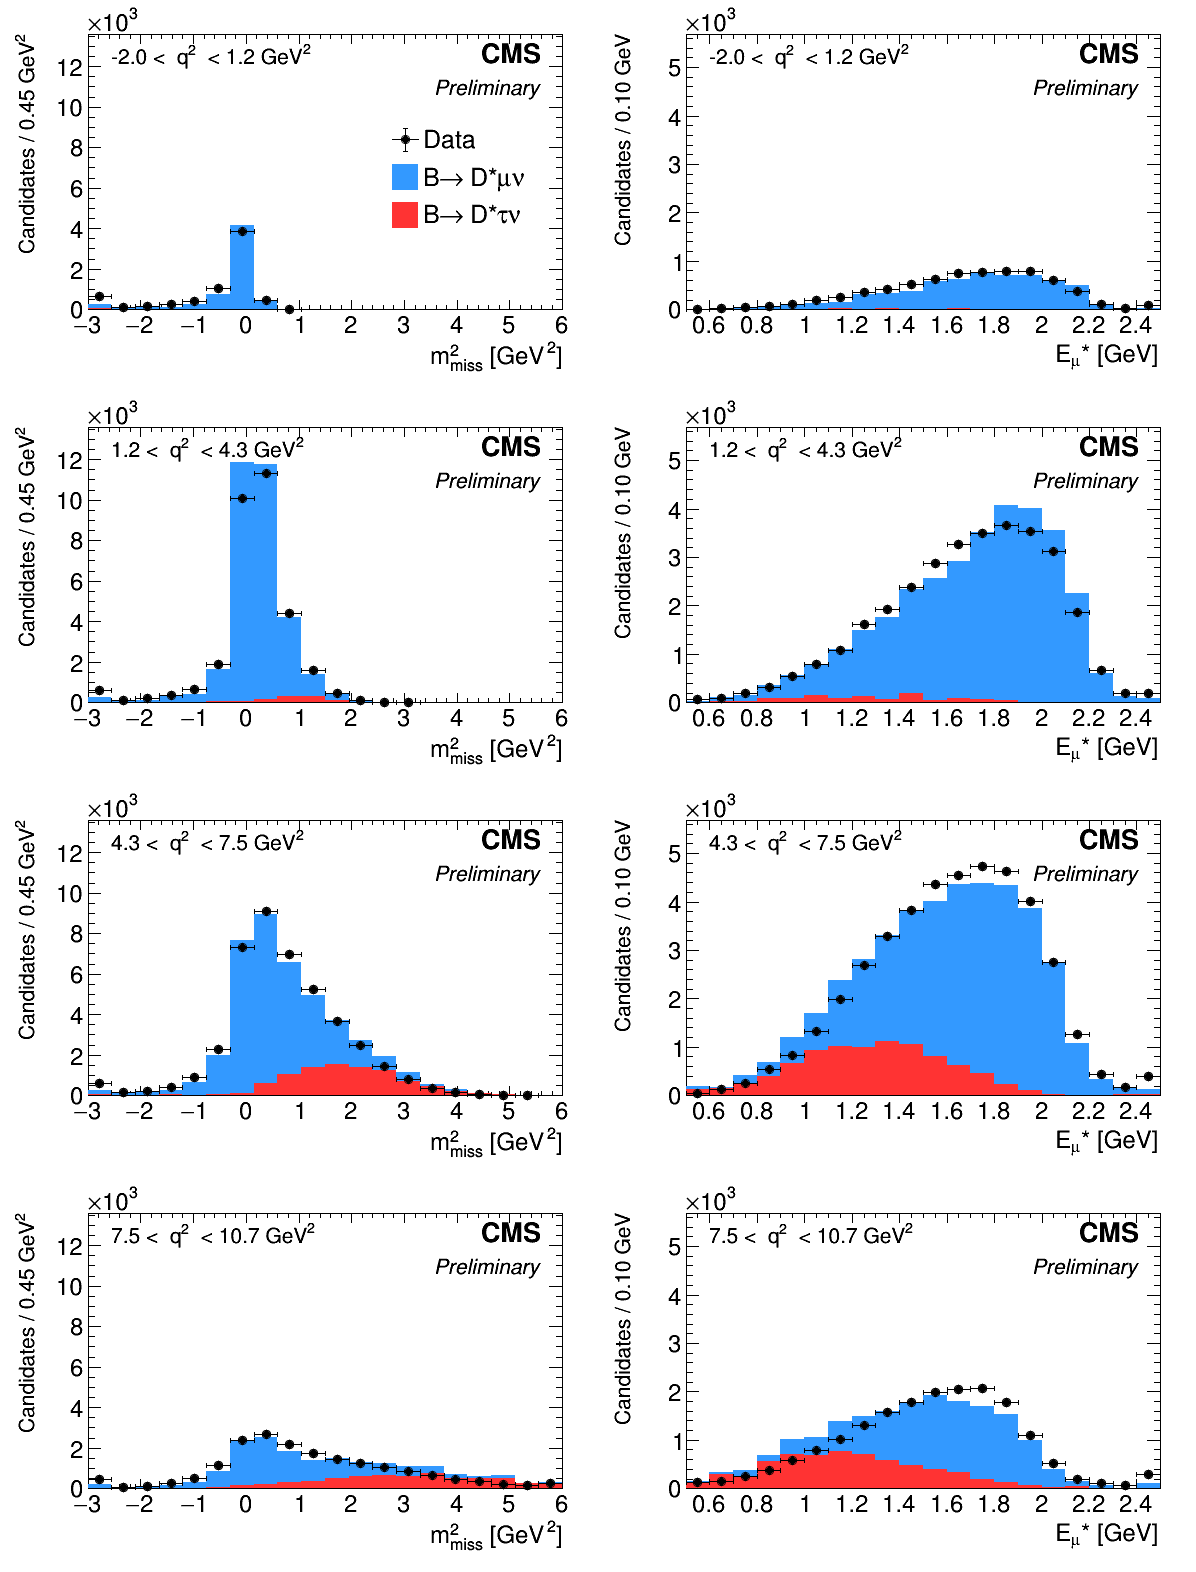

In [58]:
scale_dic = {'tau':N_B2mu_inj*rawR_inj, 
             'mu':N_B2mu_inj}

c = plot_gridVarQ2(CMS_lumi, binning, histo, scale_dic)

# for i in range(1, 1+2*binning['q2'][0]):
#     p = c.cd(i)
#     p.SetLogy()

# Write the card

In [39]:
sig_processes = ['tau', 'mu']
bkg_processes = []
processes = sig_processes + bkg_processes
categories = np.sort([k for k in histo.keys() if not '__' in k])

In [40]:
card_location = 'cards/{}.txt'.format(card_name)
fc = open(card_location, 'w')

In [41]:
# number of different categories
card = 'imax *\n'
# number of processes minus one
card += 'jmax {}\n'.format(len(processes)-1)
# number of nuissance parameters
card += 'kmax *\n'
card += '-------------------------------\n'

In [42]:
for k in categories:
    card += 'shapes * {} {} $PROCESS $PROCESS__$SYSTEMATIC\n'.format(k, histo_file_loc[k])
card += '-------------------------------\n'

In [43]:
card += 'bin ' + ' '.join(categories) + '\n'
obs = map(lambda k: '{:.0f}'.format(histo[k]['data'].Integral()), categories)
obs = ' '.join(obs)
card += 'observation ' + obs + '\n'
card += '-------------------------------\n'

In [44]:
aux_bin = ''
aux_proc_name = ''
aux_proc_id = ''
aux_proc_rate = ''
for c, p in itertools.product(categories, processes):
    aux_bin += ' '+c
    aux_proc_name += ' '+p
    aux_proc_id += ' '+str(np.argmax(np.array(processes) == p))
    aux_proc_rate += ' {}'.format(histo[c][p].Integral())
    
card += 'bin' + aux_bin + '\n'
card += 'process' + aux_proc_name + '\n'
# Zero or negative for sig and positive for bkg
card += 'process' + aux_proc_id + '\n'
# Expected rate
card += 'rate' + aux_proc_rate + '\n'
card += '-------------------------------\n'

Add additional rate parameters

In [45]:
card += 'N_B2mu rateParam * tau {}\n'.format(N_B2mu_inj)
card += 'N_B2mu rateParam * mu {}\n'.format(N_B2mu_inj)
card += '-------------------------------\n'

Systematics

In [46]:
aux_B0pT = ''
for c, p in itertools.product(categories, processes):
    if p in ['tau', 'mu']:
        aux_B0pT += ' 1.50'
    else:
        aux_B0pT += ' -'
card += 'B0pT lnN' + aux_B0pT + '\n'

MC statistic systematics

In [47]:
card += '* autoMCStats 10 1 1\n'
card += '-------------------------------\n'

In [48]:
print card

imax *
jmax 1
kmax *
-------------------------------
shapes * Est_mu_q2-0 ../data/_root/histos4combine/Cat_q2var_sys_test_Est_mu_q2-0.root $PROCESS $PROCESS__$SYSTEMATIC
shapes * Est_mu_q2-1 ../data/_root/histos4combine/Cat_q2var_sys_test_Est_mu_q2-1.root $PROCESS $PROCESS__$SYSTEMATIC
shapes * Est_mu_q2-2 ../data/_root/histos4combine/Cat_q2var_sys_test_Est_mu_q2-2.root $PROCESS $PROCESS__$SYSTEMATIC
shapes * Est_mu_q2-3 ../data/_root/histos4combine/Cat_q2var_sys_test_Est_mu_q2-3.root $PROCESS $PROCESS__$SYSTEMATIC
shapes * M2_miss_q2-0 ../data/_root/histos4combine/Cat_q2var_sys_test_M2_miss_q2-0.root $PROCESS $PROCESS__$SYSTEMATIC
shapes * M2_miss_q2-1 ../data/_root/histos4combine/Cat_q2var_sys_test_M2_miss_q2-1.root $PROCESS $PROCESS__$SYSTEMATIC
shapes * M2_miss_q2-2 ../data/_root/histos4combine/Cat_q2var_sys_test_M2_miss_q2-2.root $PROCESS $PROCESS__$SYSTEMATIC
shapes * M2_miss_q2-3 ../data/_root/histos4combine/Cat_q2var_sys_test_M2_miss_q2-3.root $PROCESS $PROCESS__$SYSTEMATIC
---

In [49]:
fc.write(card)
fc.close()

### Create output directory

In [50]:
outdir = 'results/' + card_name

if os.path.isdir(outdir):
    os.system('rm -rf ' + outdir)
os.system('mkdir ' + outdir);

# Run Combine

### Run the Maximum Likelyhood fit

In [51]:
cmd = 'combine'
cmd += ' -M FitDiagnostics'
cmd += ' --robustFit 1'
cmd += ' --skipBOnlyFit'
cmd += ' -d ' + card_location
cmd += ' -D ' + histo[histo.keys()[0]]['data'].GetName()
cmd += ' --X-rtd MINIMIZER_analytic'
cmd += ' --setParameters r=0.1'
cmd += ' --setParameterRanges r=0.001,1'
cmd += ' --trackParameters N_B2mu'
cmd += ' -n {}'.format(card_name)
cmd += ' --out ' + outdir
cmd += ' --saveShapes --saveWithUncertainties'
cmd += ' --plots'
cmd += ' --verbose -1'

In [52]:
print cmd
os.system(cmd)
os.system('mv combine_logger.out ' + outdir + '/')
os.system('mv ./*.root ' + outdir + '/')

combine -M FitDiagnostics --robustFit 1 --skipBOnlyFit -d cards/Cat_q2var_sys_test.txt -D data --X-rtd MINIMIZER_analytic --setParameters r=0.1 --setParameterRanges r=0.001,1 --trackParameters N_B2mu -n Cat_q2var_sys_test --out results/Cat_q2var_sys_test --saveShapes --saveWithUncertainties --plots --verbose -1


0

 <<< Combine >>> 
   Options for Robust Minimizer :: 
        Tolerance  0.1
        Strategy   0
        Type,Algo  Minuit2,Migrad
>>> method used is FitDiagnostics
>>> random number generator seed is 123456
Channel Est_mu_q2-0 will use autoMCStats with settings: event-threshold=10, include-signal=1, hist-mode=1
Analysing bin errors for: prop_binEst_mu_q2-0
Poisson cut-off: 10
Bin        Contents        Error           Notes                         
0          13.812656       49.564310       total sum                     
0          0.000000        0.000000        Unweighted events, alpha=inf  
  => Number of weighted events is below poisson threshold
    mu                   0.000167        0.000118                                      
                         2.000000        1.414214        Unweighted events, alpha=0.000084
      => Product of prop_binEst_mu_q2-0_bin0_mu[2.00,0.00,33.79] and const [0.5000] to be poisson constrained
  ------------------------------------------------

Channel Est_mu_q2-0 has bin 19 fill in data but empty in all backgrounds
Channel M2_miss_q2-0 has bin 9 fill in data but empty in all backgrounds
Channel M2_miss_q2-1 has bin 14 fill in data but empty in all backgrounds
Missing background ModelConfig 'ModelConfig_bonly' in workspace 'w' in file roostats-PG4j2h.root
Will make one from the signal ModelConfig 'ModelConfig' setting signal strenth 'r' to zero


In [55]:
!echo $CMSSW_BASE

/storage/user/ocerri/work/CMSSW_10_2_13


In [54]:
f = ur.open(glob(outdir + '/higgsCombine{}.FitDiagnostics.mH120.root'.format(card_name))[0])
c, d, u, _ = f['limit']['limit'].array()
print 'r = {:.3f} +{:.3f}/-{:.3f}'.format(c, u-c, c-d)

N_B2mu = f['limit']['trackedParam_N_B2mu'].array()[0]
print 'N_B2mu = {:.0f}'.format(N_B2mu)

scale_dic = {'tau':N_B2mu*c, 
             'mu':N_B2mu}

c_out = plot_gridVarQ2(CMS_lumi, binning, histo, scale_dic)

ValueError: need more than 0 values to unpack

In [ ]:
cmd = 'combine'
cmd += ' -M MultiDimFit'
cmd += ' --algo grid --points=500'
cmd += ' --robustFit 1'
cmd += ' -d ' + card_location
cmd += ' -D ' + histo[histo.keys()[0]]['data'].GetName()
cmd += ' --X-rtd MINIMIZER_analytic'
cmd += ' --setParameters r=0.1'
cmd += ' --rMin={} --rMax={}'.format(c - 10*(c-d), c + 10*(u-c))
cmd += ' --trackParameters N_B2mu'
cmd += ' -n {}'.format(card_name)
cmd += ' --saveWorkspace'
cmd += ' --verbose -1'

In [ ]:
print cmd
os.system(cmd)
os.system('mv combine_logger.out ' + outdir + '/')
os.system('mv ./*.root ' + outdir + '/')
os.system('mv ./*.dot ' + outdir + '/')

In [ ]:
f = ur.open(glob(outdir + '/higgsCombine{}.MultiDimFit.mH120.root'.format(card_name))[0])
y = 2*f['limit']['deltaNLL'].array()
x = f['limit']['r'].array()
plt.plot(x[1:],y[1:], '.--')
plt.xlabel('r')
plt.ylabel(r'2$\Delta$NLL')
r_low = interp1d(y[x < x[0]], x[x < x[0]], kind='cubic')(4.)
r_high = interp1d(y[x > x[0]], x[x > x[0]], kind='cubic')(4.)
y_min = np.min(y[1:])
plt.plot(2*[r_low], [y_min, 4], 'g')
plt.plot(2*[r_high], [y_min, 4], 'g')
plt.plot(x, [4]*x.shape[0])
plt.yscale('log')
# plt.xlim(0.08, 0.11)
print 'r = {:.3f} +{:.3f}/-{:.3f}'.format(x[0], x[0]-r_low, r_high-x[0])

### Run the Goodness of fit test

Run the observed test stat value

In [ ]:
cmd = 'combine'
cmd += ' -M GoodnessOfFit'
cmd += ' -d ' + card_location
cmd += ' -D ' + histo[histo.keys()[0]]['data'].GetName()
cmd += ' -n Obs'                                    # Just the output name
cmd += ' -t 0'                                      # Don't run toys
cmd += ' -s -1'                                     # Random seed
cmd += ' --toysNoSystematics --algo=saturated'
# cmd += ' --toysFrequentist'
cmd += ' --X-rtd MINIMIZER_analytic'
cmd += ' --setParameters r=0.1'
cmd += ' --setParameterRanges r=0.001,1'
cmd += ' --trackParameters N_B2mu'
cmd += ' --plots'
cmd += ' --verbose 9'

In [ ]:
print cmd
os.system(cmd)

Run the test stat toy distribution

In [ ]:
cmd = 'combine'
cmd += ' -M GoodnessOfFit'
cmd += ' -d ' + card_location
cmd += ' -D ' + histo[histo.keys()[0]]['data'].GetName()
cmd += ' -n Toys'                                   # Just the output name
cmd += ' -t 300'                                    # Number of toys to run
cmd += ' -s -1'                                     # Random seed
cmd += ' --toysNoSystematics --algo=saturated'
# cmd += ' --toysFrequentist'
# cmd += '--expectSignal=0'                           # Depending on the hypothesis to test. If none, r is fluctruated
cmd += ' --X-rtd MINIMIZER_analytic'
cmd += ' --setParameters r=0.1'
cmd += ' --setParameterRanges r=0.001,1'
cmd += ' --trackParameters N_B2mu'
cmd += ' --plots'
cmd += ' --verbose 1'

In [ ]:
print cmd
os.system(cmd)

Combine them to get the p-value

In [ ]:
name_obs = glob('higgsCombineObs.GoodnessOfFit.*.root')[0]
name_toys = glob('higgsCombineToys.GoodnessOfFit.*.root')[0]

In [ ]:
f = ur.open(name_obs)
s_obs = f['limit']['limit'].array()[0]

f = ur.open(name_toys)
s_toys = f['limit']['limit'].array()

p_val = np.sum(s_toys > s_obs)/float(s_toys.shape[0])
print 'p-value: {:.1f}%'.format(100*p_val)
if p_val < 0.01: print p_val

In [ ]:
# cmd = 'combineTool.py'
# cmd += ' -M CollectGoodnessOfFit'
# cmd += ' --mass 120'
# cmd += ' -o gof.json'
# cmd += ' --input {} {}'.format(name_obs, name_toys)
# print cmd
# os.system(cmd)
# os.system('plotGof.py gof.json -o gof --mass 120.0')

In [ ]:
os.system('mv *.root {}/'.format(outdir))
os.system('mv *.dot {}/'.format(outdir))
os.system('mv *.out {}/'.format(outdir))